<a href="https://colab.research.google.com/github/hongjai-rhee/public/blob/master/GARCH%EA%B2%80%EC%A0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GARCH 모형은 popular하게 사용되고 있다. 이러한 parametric volatility 모형이 얼마나 적합할까. semi-parametric form으로 error variance를 모델링하고, 그 결과를 토대로 GARCH type 모형의 적합성을 베이지언 관점에서 분석하여 본다/

                 High        Low       Open      Close      Volume  Adj Close
Date                                                                         
2018-01-02  2695.8899  2682.3601  2683.7300  2695.8101  3367250000  2695.8101
2018-01-03  2714.3701  2697.7700  2697.8501  2713.0601  3538660000  2713.0601
2018-01-04  2729.2900  2719.0701  2719.3101  2723.9900  3695260000  2723.9900
2018-01-05  2743.4500  2727.9199  2731.3301  2743.1499  3236620000  2743.1499
2018-01-08  2748.5100  2737.6001  2742.6699  2747.7100  3242650000  2747.7100
...               ...        ...        ...        ...         ...        ...
2020-11-23  3589.8101  3552.7700  3566.8201  3577.5901  5036290000  3577.5901
2020-11-24  3642.3101  3594.5200  3594.5200  3635.4099  6267570000  3635.4099
2020-11-25  3635.5000  3617.7600  3635.5000  3629.6499  4902560000  3629.6499
2020-11-27  3644.3101  3629.3301  3638.5500  3638.3501  2778450000  3638.3501
2020-11-30  3634.1799  3594.3899  3634.1799  3621.6299  62914000

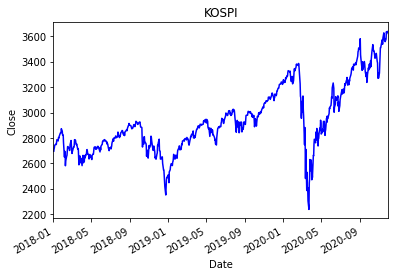

In [155]:
!pip install arviz==0.6.1
!pip install pymc3==3.8

import arviz as az
import pymc3 as pm

import pandas_datareader as wb
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np

 
pd.set_option('precision', 4)
 
start = datetime.datetime(2018, 1, 1)
end = datetime.datetime(2020, 11, 30)
df_null = wb.DataReader('^GSPC',"yahoo",start,end)  ##KS11

df = df_null.dropna()
 
kospi_chart = df.Close.plot(style='b')
kospi_chart.set_title('KOSPI')
kospi_chart.set_ylabel("Close")
kospi_chart.set_xlim(str(start), str(end))
 
print(df)
 
#print("Close Median", df['Close'].median())
#print(df['Close'].describe())
#print(df.corr())
 
plt.show()

In [134]:
returns=df
returns

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,2695.8899,2682.3601,2683.7300,2695.8101,3367250000,2695.8101
2018-01-03,2714.3701,2697.7700,2697.8501,2713.0601,3538660000,2713.0601
2018-01-04,2729.2900,2719.0701,2719.3101,2723.9900,3695260000,2723.9900
2018-01-05,2743.4500,2727.9199,2731.3301,2743.1499,3236620000,2743.1499
2018-01-08,2748.5100,2737.6001,2742.6699,2747.7100,3242650000,2747.7100
...,...,...,...,...,...,...
2020-11-23,3589.8101,3552.7700,3566.8201,3577.5901,5036290000,3577.5901
2020-11-24,3642.3101,3594.5200,3594.5200,3635.4099,6267570000,3635.4099
2020-11-25,3635.5000,3617.7600,3635.5000,3629.6499,4902560000,3629.6499


In [135]:
returns=df
returns["change"] = np.log(returns["Close"]).diff()
returns = returns.dropna()
returns.head()

Y=returns.change

,High,Low,Open,Close,Volume,Adj Close,change
Date,,,,,,,
2018-01-03,2714.3701,2697.7700,2697.8501,2713.0601,3538660000,2713.0601,0.0064
2018-01-04,2729.2900,2719.0701,2719.3101,2723.9900,3695260000,2723.9900,0.0040
2018-01-05,2743.4500,2727.9199,2731.3301,2743.1499,3236620000,2743.1499,0.0070
2018-01-08,2748.5100,2737.6001,2742.6699,2747.7100,3242650000,2747.7100,0.0017
2018-01-09,2759.1399,2747.8601,2751.1499,2751.2900,3453480000,2751.2900,0.0013


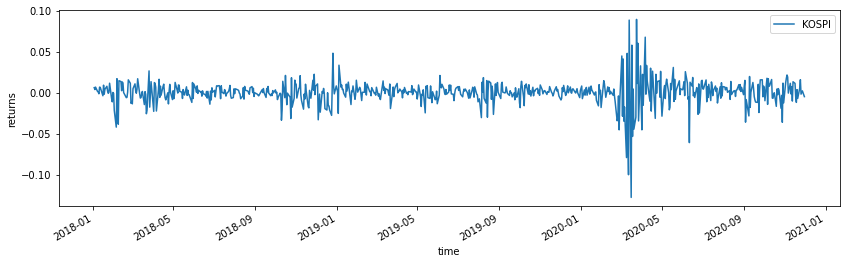

In [137]:
fig, ax = plt.subplots(figsize=(14, 4))
returns.plot(y="change", label='KOSPI', ax=ax)
ax.set(xlabel='time', ylabel='returns')
ax.legend();

In [138]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
        step_size = pm.Exponential('step_size', 10)
        volatility = pm.GaussianRandomWalk('volatility', sigma=step_size, shape=len(Y))
        mu = pm.Normal('mu', mu=0, sd=10)
        var = pm.Deterministic('variance', tt.exp(-volatility)**2)
        like = pm.Normal('likelihood',  mu=mu, sd=tt.sqrt(var), observed=Y)                        
        trace = pm.sample(2000, chains=1, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu, volatility, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 3000/3000 [01:26<00:00, 34.80it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


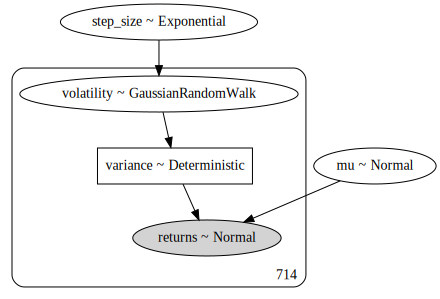

In [62]:
pm.model_to_graphviz(model)


/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not 

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
volatility[0],4.888,0.243,4.440,5.337,0.005,0.003,2474.0,2474.0,2535.0,1660.0,NaN
volatility[1],4.893,0.233,4.461,5.328,0.005,0.003,2290.0,2290.0,2350.0,1480.0,NaN
volatility[2],4.916,0.229,4.502,5.341,0.005,0.003,2258.0,2258.0,2288.0,1652.0,NaN
volatility[3],4.930,0.227,4.485,5.326,0.005,0.004,1758.0,1743.0,1747.0,1454.0,NaN
volatility[4],4.943,0.226,4.491,5.333,0.006,0.004,1673.0,1629.0,1569.0,1553.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
variance[709],0.000,0.000,0.000,0.000,0.000,0.000,2004.0,1589.0,2993.0,1318.0,NaN
variance[710],0.000,0.000,0.000,0.000,0.000,0.000,2175.0,1683.0,2961.0,1486.0,NaN
variance[711],0.000,0.000,0.000,0.000,0.000,0.000,1970.0,1575.0,2538.0,1537.0,NaN
variance[712],0.000,0.000,0.000,0.000,0.000,0.000,1856.0,1525.0,2530.0,1619.0,NaN


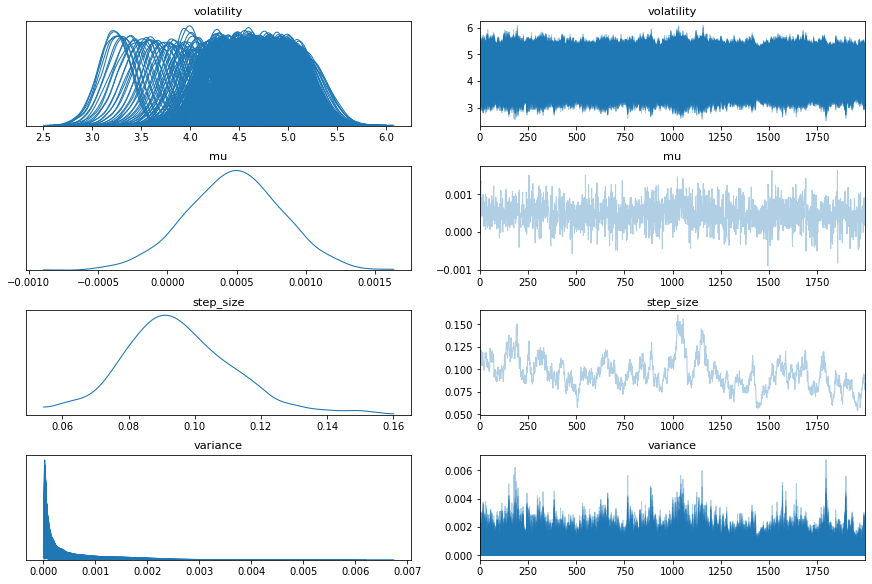

In [122]:
pm.traceplot(trace)
pm.summary(trace)

# 포스티리어 회귀분석

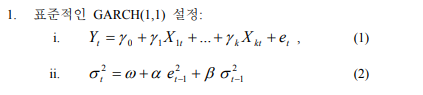

In [139]:
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

# Constant Volatility

,0
count,2.0000e+03
mean,-2.5424e-17
std,2.3640e-16
min,-8.8818e-16
25%,-2.2204e-16
50%,0.0000e+00
75%,1.1102e-16
max,7.7716e-16


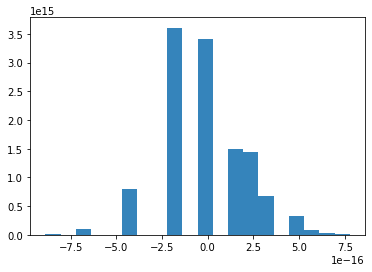

In [149]:

niter=len(trace)
r2=np.zeros(niter)
T=len(Y)
#trace.variance[:,700].shape
#trace.mu[0]

for i in range(niter):
  lhs = trace.variance[i,1:T]
  rhs1 = (Y[0:T-1] - trace.mu[i])**2 
  rhs2 = trace.variance[i, 0:T-1]

  ## 회귀분석
  X2=np.ones(T-1)
  y = lhs
#  X2 = sm.add_constant(X) 
  est = sm.OLS(y, X2)
  est2 = est.fit()
  r2[i]= est2.rsquared_adj
plt.hist(r2, bins=20, density=True, alpha=0.9, histtype='stepfilled')
r2=pd.DataFrame(r2)
r2.describe()

# GARCH(1,0)

,0
count,2000.0000
mean,0.4534
std,0.0820
min,0.1976
25%,0.3972
50%,0.4548
75%,0.5074
max,0.7239


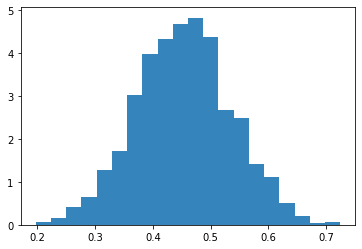

In [147]:

niter=len(trace)
r2=np.zeros(niter)
T=len(Y)
#trace.variance[:,700].shape
#trace.mu[0]

for i in range(niter):
  lhs = trace.variance[i,1:T]
  rhs1 = (Y[0:T-1] - trace.mu[i])**2 
  rhs2 = trace.variance[i, 0:T-1]

  ## 회귀분석
#  X=np.vstack([rhs1, rhs2]).T
  X=rhs1
  y = lhs
  X2 = sm.add_constant(X) 
  est = sm.OLS(y, X2)
  est2 = est.fit()
  r2[i]= est2.rsquared_adj
plt.hist(r2, bins=20, density=True, alpha=0.9, histtype='stepfilled')
r2=pd.DataFrame(r2)
r2.describe()

# GARCH(0,1)

,0
count,2000.0000
mean,0.8988
std,0.0346
min,0.7033
25%,0.8809
50%,0.9052
75%,0.9233
max,0.9619


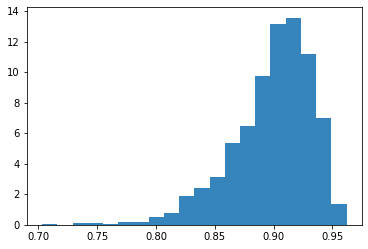

In [146]:

niter=len(trace)
r2=np.zeros(niter)
T=len(Y)
#trace.variance[:,700].shape
#trace.mu[0]

for i in range(niter):
  lhs = trace.variance[i,1:T]
  rhs1 = (Y[0:T-1] - trace.mu[i])**2 
  rhs2 = trace.variance[i, 0:T-1]

  ## 회귀분석
#  X=np.vstack([rhs1, rhs2]).T
  X=rhs2
  y = lhs
  X2 = sm.add_constant(X) 
  est = sm.OLS(y, X2)
  est2 = est.fit()
  r2[i]= est2.rsquared_adj
plt.hist(r2, bins=20, density=True, alpha=0.9, histtype='stepfilled')
r2=pd.DataFrame(r2)
r2.describe()

# GARCH(1,1)

,0
count,2000.0000
mean,0.9044
std,0.0331
min,0.7065
25%,0.8888
50%,0.9104
75%,0.9272
max,0.9694


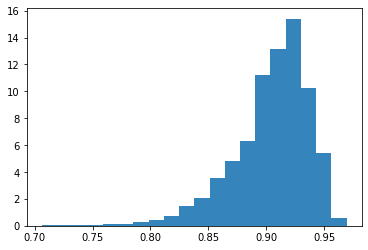

In [144]:
niter=len(trace)
r2=np.zeros(niter)
T=len(Y)
#trace.variance[:,700].shape
#trace.mu[0]

for i in range(niter):
  lhs = trace.variance[i,1:T]
  rhs1 = (Y[0:T-1] - trace.mu[i])**2 
  rhs2 = trace.variance[i, 0:T-1]

  ## 회귀분석
  X=np.vstack([rhs1, rhs2]).T
  y = lhs
  X2 = sm.add_constant(X) 
  est = sm.OLS(y, X2)
  est2 = est.fit()
  r2[i]= est2.rsquared_adj
plt.hist(r2, bins=20, density=True, alpha=0.9, histtype='stepfilled')
r2=pd.DataFrame(r2)
r2.describe()

# GJR GARCH(1,1)

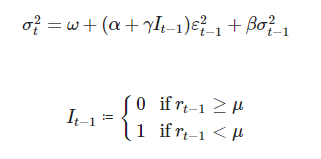

,0
count,2000.0000
mean,0.9088
std,0.0311
min,0.7167
25%,0.8931
50%,0.9145
75%,0.9306
max,0.9710


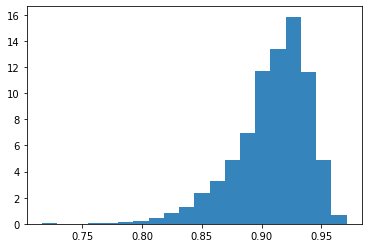

In [156]:
niter=len(trace)
r2=np.zeros(niter)
T=len(Y)
#trace.variance[:,700].shape
#trace.mu[0]

for i in range(niter):
  lhs = trace.variance[i,1:T]
  rhs1 = (Y[0:T-1] - trace.mu[i])**2 
  rhs2 = trace.variance[i, 0:T-1]

  dummy = 1*(Y[0:T-1] < trace.mu[i])*rhs1   ## negative shock 의 additional effect
  
  ## 회귀분석
  X=np.vstack([rhs1, rhs2, dummy]).T
  y = lhs
  X2 = sm.add_constant(X) 
  est = sm.OLS(y, X2)
  est2 = est.fit()
  r2[i]= est2.rsquared_adj
plt.hist(r2, bins=20, density=True, alpha=0.9, histtype='stepfilled')
r2=pd.DataFrame(r2)
r2.describe()

In [157]:
print("summary()\n",est2.summary())

summary()
                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     3035.
Date:                Sat, 19 Dec 2020   Prob (F-statistic):               0.00
Time:                        01:50:47   Log-Likelihood:                 5350.5
No. Observations:                 732   AIC:                        -1.069e+04
Df Residuals:                     728   BIC:                        -1.067e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.016e-05   6.42e-06      1.5